In [647]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import  RandomForestRegressor
from sklearn.tree import  DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import plot_tree
import json
from scipy.stats import zscore
from sklearn.model_selection import GridSearchCV
RSEED = 42


In [648]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0


In [649]:
df_train["STA"] = df_train['STA'].str.replace(".", ":")
df_train["STA"] = pd.to_datetime(df_train["STA"])
df_train["STD"] = pd.to_datetime(df_train["STD"])
df_train["DATOP"] = pd.to_datetime(df_train["DATOP"], format='%Y-%m-%d')

df_train["airline_code"] = df_train['FLTID'].str.split(' ').str[0]
df_train["flt_num"] = df_train['FLTID'].str.split(' ').str[1]
df_train["AC_num"] = df_train['AC'].str.split(' ').str[1]
df_train["STD_year"] = df_train['STD'].dt.year
df_train["STD_month"] = df_train['STD'].dt.month
df_train["STD_day"] = df_train['STD'].dt.day_of_week
df_train["STD_hour"] = df_train['STD'].dt.hour
df_train["STA_hour"] = df_train['STA'].dt.hour
df_train["DURATION"] = (df_train.STA - df_train.STD) / timedelta(minutes = 1)
df_train["plane"] = df_train['AC'].str.split(' ').str[1].str[:3]
df_train["route"] = df_train["DEPSTN"] + "-" + df_train["ARRSTN"]
# Count the occurrences of each DATOP value
datop_counts = df_train['DATOP'].value_counts()
# Map the counts to a new column in df_train
df_train['DATOP_count'] = df_train['DATOP'].map(datop_counts)
datop_dep_counts = df_train.groupby(['DATOP', 'DEPSTN']).size()# Group by DATOP and DEPSTN and calculate the occurrences
df_train['DATOP_DEP_count'] = df_train.set_index(['DATOP', 'DEPSTN']).index.map(datop_dep_counts)# Map the counts to a new column in df_train

datop_arr_counts = df_train.groupby(['DATOP', 'ARRSTN']).size()# Group by DATOP and ARRST and calculate the occurrences
df_train['DATOP_ARR_count'] = df_train.set_index(['DATOP', 'ARRSTN']).index.map(datop_arr_counts)# Map the counts to a new column in df_train

with open('Airports-master/airports.json', 'r') as f:
    data = json.load(f)

airports = []
for airport_code, details in data.items():
    record = {
        'iata': details.get('iata', ''),
        'country': details.get('country', ''),
        'lon': details.get('lon', None),
        'lat': details.get('lat', None)
    }
    airports.append(record)

df_airports = pd.DataFrame(airports)

df_train = df_train.merge(
    df_airports[['iata', 'lat', 'lon']],
    left_on='DEPSTN',
    right_on='iata',
    how='left'
).rename(columns={
    'lat': 'DEP_lat',
    'lon': 'DEP_lon',
}).drop(columns=['iata'])  # Drop redundant 'iata' after merge

df_train = df_train.merge(
    df_airports[['iata', 'lat', 'lon']],
    left_on='ARRSTN',
    right_on='iata',
    how='left'
).rename(columns={
    'lat': 'ARR_lat',
    'lon': 'ARR_lon',
}).drop(columns=['iata'])  # Drop redundant 'iata' after second merge

df_train.head()
df_train.dropna(axis=0)

# Define a function to categorize hours
def categorize_hour(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'noon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

# Apply the function to categorize STD_hour and STA_hour
df_train['STD_hour_category'] = df_train['STD_hour'].apply(categorize_hour)

#hot-encoede the plane-column
plane = pd.get_dummies(df_train['plane'], prefix='plane', dtype = int, drop_first=True) # not sure about dropping first

#hot-encoede the routes
route = pd.get_dummies(df_train['route'], prefix='route', dtype = int, drop_first=True) # not sure about dropping first

# hot-encode daytime one-hot encoding
daytime = pd.get_dummies(df_train['STD_hour_category'], prefix='daytime', dtype = int)# not sure about dropping first

# hot-encode status
status = pd.get_dummies(df_train['STATUS'], prefix='status', dtype = int) # not sure about dropping first
# hot-encode airports_dep
airports_dep = pd.get_dummies(df_train['DEPSTN'], prefix='DEPSTN', dtype = int) # not sure about dropping first
# hot-encode airports_arrv
airports_arrv = pd.get_dummies(df_train['ARRSTN'], prefix='ARRSTN', dtype = int) # not sure about dropping first


df_train = pd.concat([df_train, daytime, route, status,plane, airports_dep, airports_arrv], axis=1)




df_train.dropna(inplace=True) # totaly optional, due to some airports which do not exist anymore and are therefore not listed in the json



df_train.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,...,ARRSTN_TRN,ARRSTN_TUN,ARRSTN_VCE,ARRSTN_VIE,ARRSTN_VKO,ARRSTN_VNO,ARRSTN_VOG,ARRSTN_VRN,ARRSTN_YUL,ARRSTN_ZRH
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,...,0,1,0,0,0,0,0,0,0,0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,...,0,1,0,0,0,0,0,0,0,0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,...,0,0,0,0,0,0,0,0,0,0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,...,0,0,0,0,0,0,0,0,0,0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,...,0,0,0,0,0,0,0,0,0,0


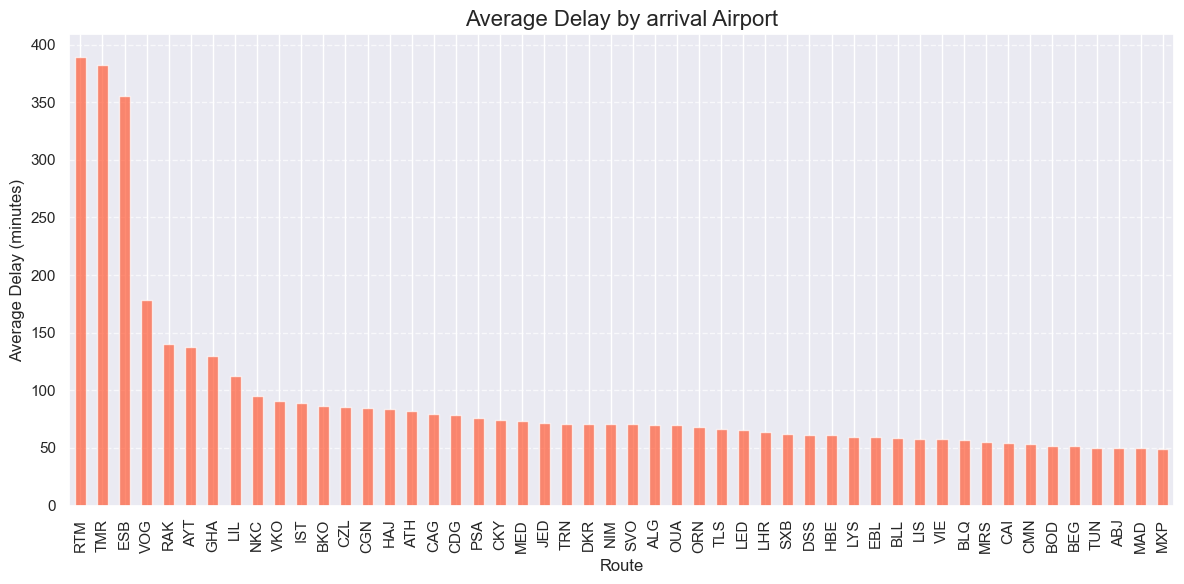

In [650]:
route_delays = df_train.groupby('ARRSTN')['target'].mean().sort_values(ascending=False)[0:50]

# Plot the routes and their corresponding delays
plt.figure(figsize=(12, 6))
route_delays.plot(kind='bar', color="#FF5A36", alpha=0.7)
plt.title("Average Delay by arrival Airport", fontsize=16)
plt.xlabel("Route", fontsize=12)
plt.ylabel("Average Delay (minutes)", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

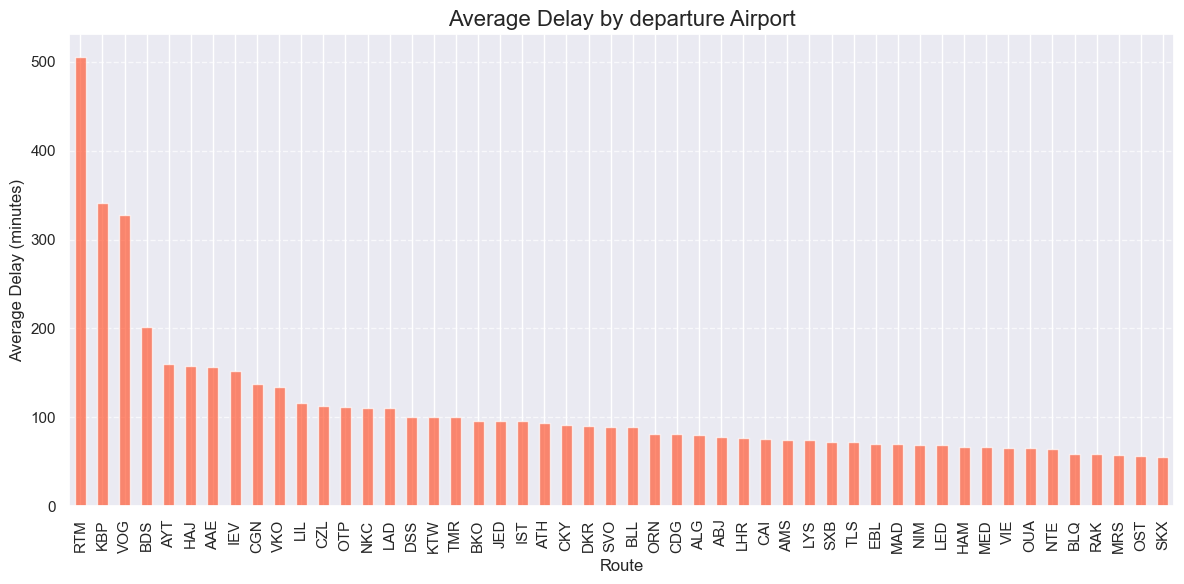

In [651]:
route_delays = df_train.groupby('DEPSTN')['target'].mean().sort_values(ascending=False)[0:50]

# Plot the routes and their corresponding delays
plt.figure(figsize=(12, 6))
route_delays.plot(kind='bar', color="#FF5A36", alpha=0.7)
plt.title("Average Delay by departure Airport", fontsize=16)
plt.xlabel("Route", fontsize=12)
plt.ylabel("Average Delay (minutes)", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

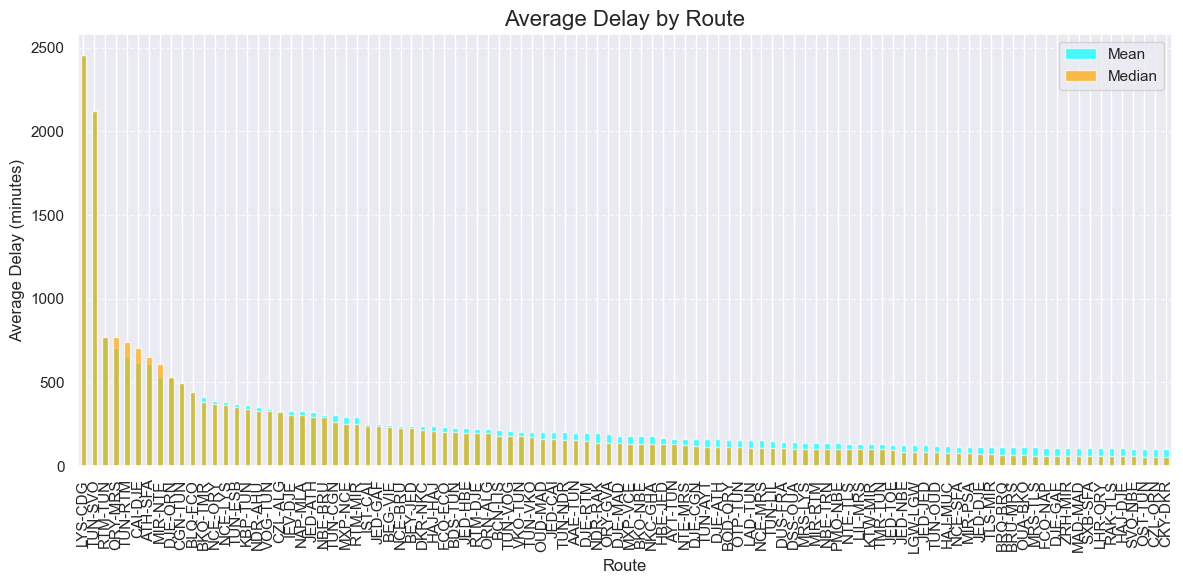

In [652]:
route_nr = 100
route_delays_median = df_train.groupby('route')['target'].median().sort_values(ascending=False)[0:route_nr]
route_delays_mean = df_train.groupby('route')['target'].mean().sort_values(ascending=False)[0:route_nr]

# Plot the routes and their corresponding delays
plt.figure(figsize=(12, 6))
route_delays_mean.plot(kind='bar', color="cyan", alpha=0.7)
route_delays_median.plot(kind='bar', color="orange", alpha=0.7)
plt.title("Average Delay by Route", fontsize=16)
plt.xlabel("Route", fontsize=12)
plt.ylabel("Average Delay (minutes)", fontsize=12)
plt.xticks(rotation=90)
plt.legend(['Mean', 'Median'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [653]:
# our dataframe contains of 10 columns and almost all of them are categorical.
# besides each of the categorical features contains of many unique values.
# we can not convert them into meaningful numbers, so we will use one hot encoding
# we need to create a dataframe which will contain only relevant features, otherwise the amouunt of features will be too high. 
# Therefore we will start with few columns, look how the model going to perform and than add more columns.

#it seems, that the most relevant columns are:

# 1. Round

# -month: since the country is very touristic, in certain months the number of flights is much higher than in others.
     # easy to implement, since no hot encoding needed
# - year: it seems that the delays incresed during the years 
     # easy to implement, since no hot encoding needed
# - day
    # easy to implement, since no hot encoding needed
# - hour of departure and arrival: it seems that the delays are higher during the day than during the night. 
     # easy to implement, since no hot encoding needed
# - duraion of the flight

# 2. Round

# -status: here the categories DEL and SCH always provide y = 0 ==> hot-encode them
# -airports: it seems that the airport show a very different delay behaviour. There are a alot of them, and we still have to encode them.
         # it might be interesting if there is an influence on the delay is identical for the same airport, regardless if it is the departure or arrival airport, would reduce the number of features




# maybe we should include the number of flights per day, since it might be that the more flights are scheduled, the higher the delay is.
     # additionally, it should be calculated for each airport

# -daytime: as exprected during the noon the delays are much higher than during the night.
         # next, we should check if there is the difference between daytime of departure and arrival
         # include later, since easier to work with hour of departure and arrival, just 2 categories


In [654]:
df_train.columns[660:730]

Index(['route_TUN-BTS', 'route_TUN-BUD', 'route_TUN-BYJ', 'route_TUN-CAG',
       'route_TUN-CAI', 'route_TUN-CDG', 'route_TUN-CGN', 'route_TUN-CKY',
       'route_TUN-CMN', 'route_TUN-COO', 'route_TUN-CPH', 'route_TUN-CTA',
       'route_TUN-CZL', 'route_TUN-DJE', 'route_TUN-DKR', 'route_TUN-DOH',
       'route_TUN-DSS', 'route_TUN-DUS', 'route_TUN-EBL', 'route_TUN-EBM',
       'route_TUN-ESB', 'route_TUN-FCO', 'route_TUN-FIH', 'route_TUN-FRA',
       'route_TUN-GAE', 'route_TUN-GAF', 'route_TUN-GVA', 'route_TUN-HAM',
       'route_TUN-HBE', 'route_TUN-IEV', 'route_TUN-IST', 'route_TUN-JED',
       'route_TUN-KBP', 'route_TUN-KGL', 'route_TUN-KRR', 'route_TUN-KRT',
       'route_TUN-LAD', 'route_TUN-LBV', 'route_TUN-LGW', 'route_TUN-LHR',
       'route_TUN-LIL', 'route_TUN-LIS', 'route_TUN-LJU', 'route_TUN-LUX',
       'route_TUN-LYS', 'route_TUN-MAD', 'route_TUN-MED', 'route_TUN-MIR',
       'route_TUN-MLA', 'route_TUN-MRS', 'route_TUN-MUC', 'route_TUN-MXP',
       'route_TUN-NAP', '

In [655]:
y = df_train['target']
#X = df_train[['STD_year', 'STD_month', 'STD_day', 'STD_hour', 'STA_hour', 'DURATION', 'status_ATA', 'status_DEL',
       #'status_DEP', 'status_RTR', 'status_SCH',
       #'DATOP_DEP_count', 'DATOP_ARR_count', 'DEP_lat',
       #'DEP_lon', 'ARR_lat', 'ARR_lon']]



X = df_train[['STD_year', 'STD_month', 'STD_day', 'STD_hour', 'STA_hour', 'DURATION', 'status_ATA', 'status_DEL',
       'status_DEP', 'status_RTR', 'status_SCH',
       'DATOP_DEP_count', 'DATOP_ARR_count', 'DEP_lat',
       'DEP_lon', 'ARR_lat', 'ARR_lon'] + airports_dep.columns.tolist()+ airports_arrv.columns.tolist()+ plane.columns.tolist()]

       
#X = df_train[['STD_year', 'STD_month', 'STD_day', 'STD_hour', 'STA_hour', 'DURATION']]#no daytime, no STATUS
#X = df_train[['STD_year', 'STD_month', 'STD_day', 'STD_hour', 'STA_hour', 'DURATION', 'status_ATA', 'status_DEL','status_DEP', 'status_RTR', 'status_SCH']]#no daytime
#X = df_train[['STD_year', 'STD_month', 'STD_day', 'DURATION', 'daytime_morning','daytime_noon', 'daytime_evening','daytime_night']]#no hours, no STATUS

In [656]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED) # no stratify, since the target is not categorical

In [657]:
# Combine X_train and y_train
train_combined = pd.concat([X_train, y_train], axis=1)

#print(f"train combined length, before removing DEL and SCH: {len(train_combined)}")
#remove all rows with DEL or SCH in STATUS from train_combined dataframe and saves them in train_combined_del_sch
#train_combined_del_sch = train_combined[(train_combined['status_DEL'] == 1) | (train_combined['status_SCH'] == 1)]
#train_combined = train_combined.drop(train_combined[(train_combined['status_DEL'] == 1) | (train_combined['status_SCH'] == 1)].index)
#print(f"train combined length, after removing DEL and SCH: {len(train_combined)}")
#print(f"train combined length, DEL and SCH: {len(train_combined_del_sch)}")


In [658]:
# Combine X_test and y_test
#test_combined = pd.concat([X_test, y_test], axis=1)

#print(f"test combined length, before removing DEL and SCH: {len(test_combined)}")
#remove all rows with DEL or SCH in STATUS from test_combined dataframe and saves them in test_combined_del_sch
#test_combined_del_sch = test_combined[(test_combined['status_DEL'] == 1) | (test_combined['status_SCH'] == 1)]
#test_combined = test_combined.drop(test_combined[(test_combined['status_DEL'] == 1) | (test_combined['status_SCH'] == 1)].index)
#print(f"test combined length, after removing DEL and SCH: {len(test_combined)}")
#print(f"test combined length, DEL and SCH: {len(test_combined_del_sch)}")

#X_test = test_combined.drop(columns=['target'])
#y_test = test_combined['target']

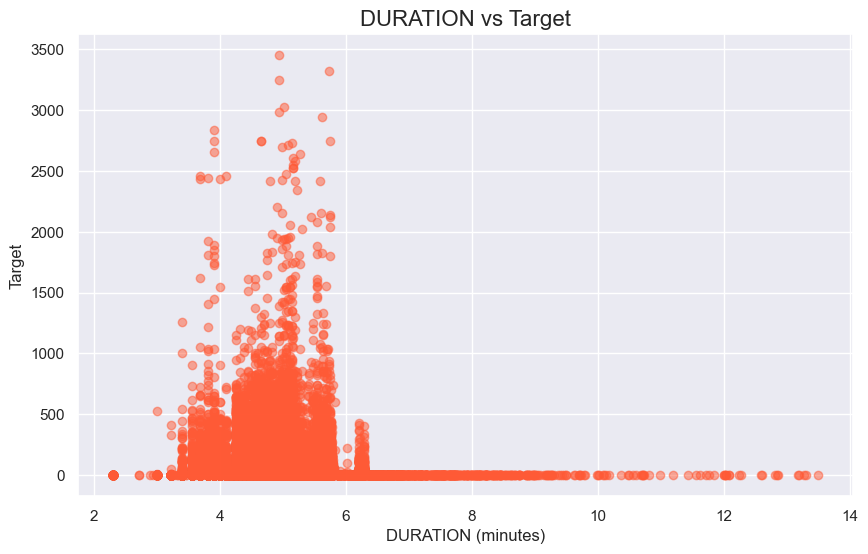

In [659]:
plt.figure(figsize=(10, 6))
plt.scatter(np.log(df_train['DURATION']), df_train['target'], alpha=0.5, color="#FF5A36")
plt.title("DURATION vs Target", fontsize=16)
plt.xlabel("DURATION (minutes)", fontsize=12)
plt.ylabel("Target", fontsize=12)
plt.grid(True)
plt.show()

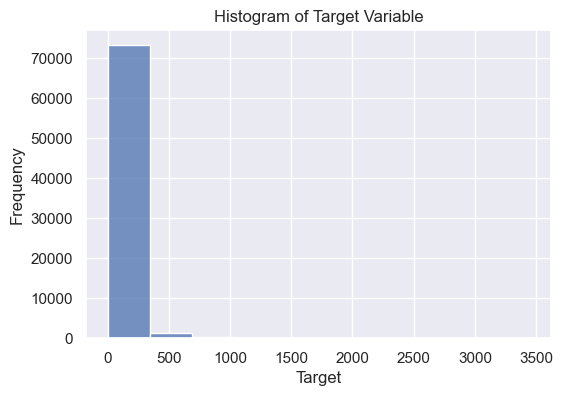

In [660]:
sns.histplot(y_train, bins=10, kde=False)
plt.title("Histogram of Target Variable")
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.show()

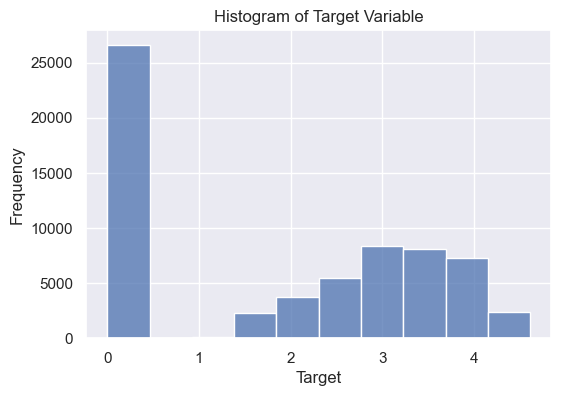

In [661]:
train_combined_log = train_combined[train_combined['target'] <= 100]# (train_combined['target'] <= 400) & (train_combined['target'] >= 0)]
X_train_log = train_combined_log.drop(columns=['target'])
y_train_log = train_combined_log['target']

y_train_log = np.log1p(y_train_log)
y_test_log = np.log1p(y_test)

sns.histplot(y_train_log, bins=10, kde=False)
plt.title("Histogram of Target Variable")
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.show()

In [662]:
y_train = y_train_log
y_test = y_test_log
X_train = X_train_log

In [635]:
# maybe try different scalers (minmax, standard or roubst)
#shouldnt be used for decision trees, since thean the columns are gone and we wouldnt be able to to the feature importance analysis and to look at the decision tree
#scaler = RobustScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [636]:
#model_dtc = DecisionTreeRegressor(random_state=RSEED, max_depth=20)
model_dtc = RandomForestRegressor(random_state=RSEED, n_estimators=200, max_depth=15, max_features ='sqrt')
model_dtc.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=200,
                      random_state=42)

In [637]:
#pred_test_dtc = model_dtc.predict(X_test)
#pred_train_dtc = model_dtc.predict(X_train)

pred_test_dtc = np.expm1(model_dtc.predict(X_test))
pred_train_dtc = np.expm1(model_dtc.predict(X_train))
y_test = np.expm1(y_test)
y_train = np.expm1(y_train)


In [638]:
#now we have to add the rows with DEl and SCH back to the dataframe
#pred_test_dtc = np.concatenate((pred_test_dtc, test_combined_del_sch['target'].values))
#X_test = np.concatenate((X_test, test_combined_del_sch.drop(columns=['target']).values))
#y_test = np.concatenate((y_test, test_combined_del_sch['target'].values))
#pred_train_dtc = np.concatenate((pred_train_dtc, train_combined_del_sch['target'].values))
#X_train = np.concatenate((X_train, train_combined_del_sch.drop(columns=['target']).values))
#y_train = np.concatenate((y_train, train_combined_del_sch['target'].values))

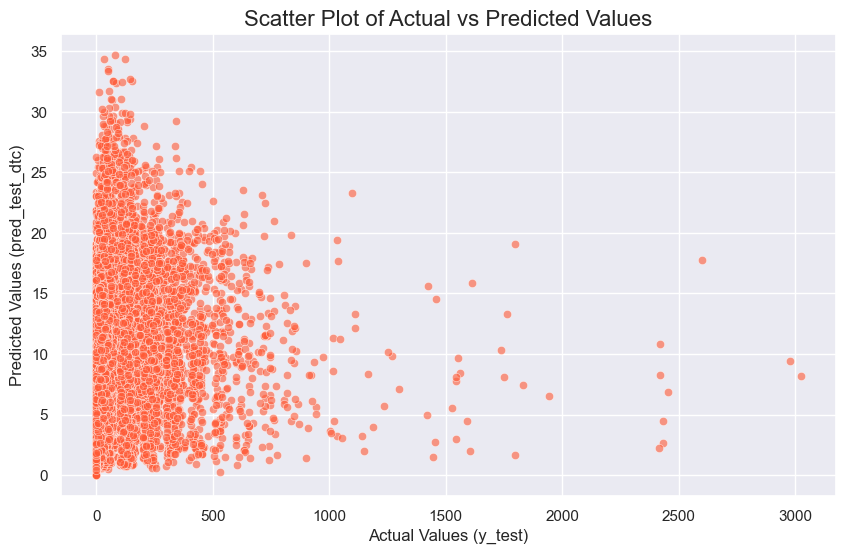

In [639]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=pred_test_dtc, alpha=0.6, color="#FF5A36")
plt.title("Scatter Plot of Actual vs Predicted Values", fontsize=16)
plt.xlabel("Actual Values (y_test)", fontsize=12)
plt.ylabel("Predicted Values (pred_test_dtc)", fontsize=12)
plt.grid(True)
plt.show()

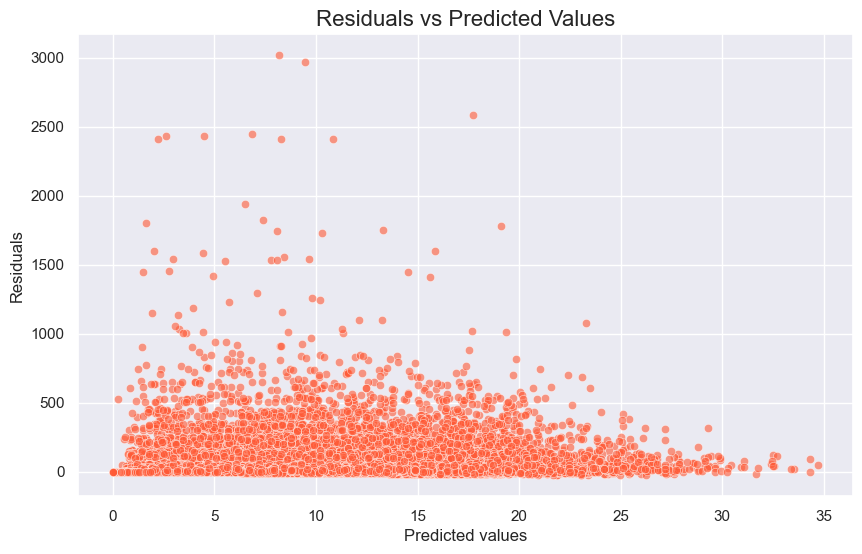

In [640]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pred_test_dtc, y=y_test-pred_test_dtc, alpha=0.6, color="#FF5A36")
plt.title("Residuals vs Predicted Values", fontsize=16)
plt.xlabel("Predicted values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.grid(True)
plt.show()

In [641]:
def calculate_metrics(y_train, y_pred_train, y_test, y_pred_test):
    """Calculate and print out RMSE and R2 for train and test data

    Args:
        y_train (array): true values of y_train
        y_pred_train (array): predicted values of model for y_train
        y_test (array): true values of y_test
        y_pred_test (array): predicted values of model for y_test
    """

    print("Metrics on training data") 
    rmse = np.sqrt(mean_squared_error(y_train,y_pred_train))
    r2 = r2_score(y_train,y_pred_train)
    mae = mean_absolute_error(y_train,y_pred_train)
    acc = abs(y_pred_train - y_train)
    acc[acc<10] = 0
    zero_count = (acc == 0).sum()
    print(f"Number of correct predictions: {zero_count/len(acc)*100:.2f}%")
    print("MAE: ", round(mae,3))
    print("RMSE:", round(rmse, 3))
    print("R2:", round(r2, 3))
    print("---"*10)
    
    # Calculate metric
    print("Metrics on test data")  
    rmse = np.sqrt(mean_squared_error(y_test,y_pred_test))
    r2 = r2_score(y_test,y_pred_test)
    mae = mean_absolute_error(y_test,y_pred_test)
    acc = abs(y_pred_test - y_test)
    acc[acc<10] = 0
    zero_count = (acc == 0).sum()
    print(f"Number of correct predictions: {zero_count/len(acc)*100:.2f}%")
    print("MAE: ", round(mae,3))
    print("RMSE:", round(rmse, 3))
    print("R2:", round(r2, 3))
    print("---"*10)



In [642]:
# Convert X_test to DataFrame and y_test to Series before concatenation
#X_test_df = pd.DataFrame(X_test, columns=features)  # Use the original feature names
#y_test_series = pd.Series(y_test, name='target')    # Name the Series as 'target'

# Convert X_train to DataFrame and pred_test_dtc to Series before concatenation
#X_pred_test_dtc_df = pd.DataFrame(X_train, columns=features)  # Use the original feature names
#y_pred_test_dtc = pd.Series(pred_test_dtc, name='target')     # Name the Series as 'target'

# Concatenate the DataFrame and Series
#df_test_end = pd.concat([X_test_df, y_test_series], axis=1)
#df_pred_test_dtc_end = pd.concat([X_pred_test_dtc_df, y_pred_test_dtc], axis=1)

In [643]:
#calculate_metrics(np.expm1(y_train), pred_train_dtc, np.expm1(y_test), pred_test_dtc)
calculate_metrics(y_train, pred_train_dtc, y_test, pred_test_dtc)

Metrics on training data
Number of correct predictions: 64.91%
MAE:  12.188
RMSE: 19.872
R2: 0.069
------------------------------
Metrics on test data
Number of correct predictions: 54.28%
MAE:  43.141
RMSE: 117.72
R2: -0.107
------------------------------


In [644]:
features = X.columns  # Use the column names of the original DataFrame X as features
fi = pd.DataFrame({'feature': features,
                   'importance': model_dtc.feature_importances_}).\
                    sort_values('importance', ascending=False)
fi.head(10)


,feature,importance
10,status_SCH,0.150949
6,status_ATA,0.119403
5,DURATION,0.079874
4,STA_hour,0.058197
14,DEP_lon,0.056948
3,STD_hour,0.052124
11,DATOP_DEP_count,0.050469
13,DEP_lat,0.050103
289,plane_AT7,0.045571
12,DATOP_ARR_count,0.037895


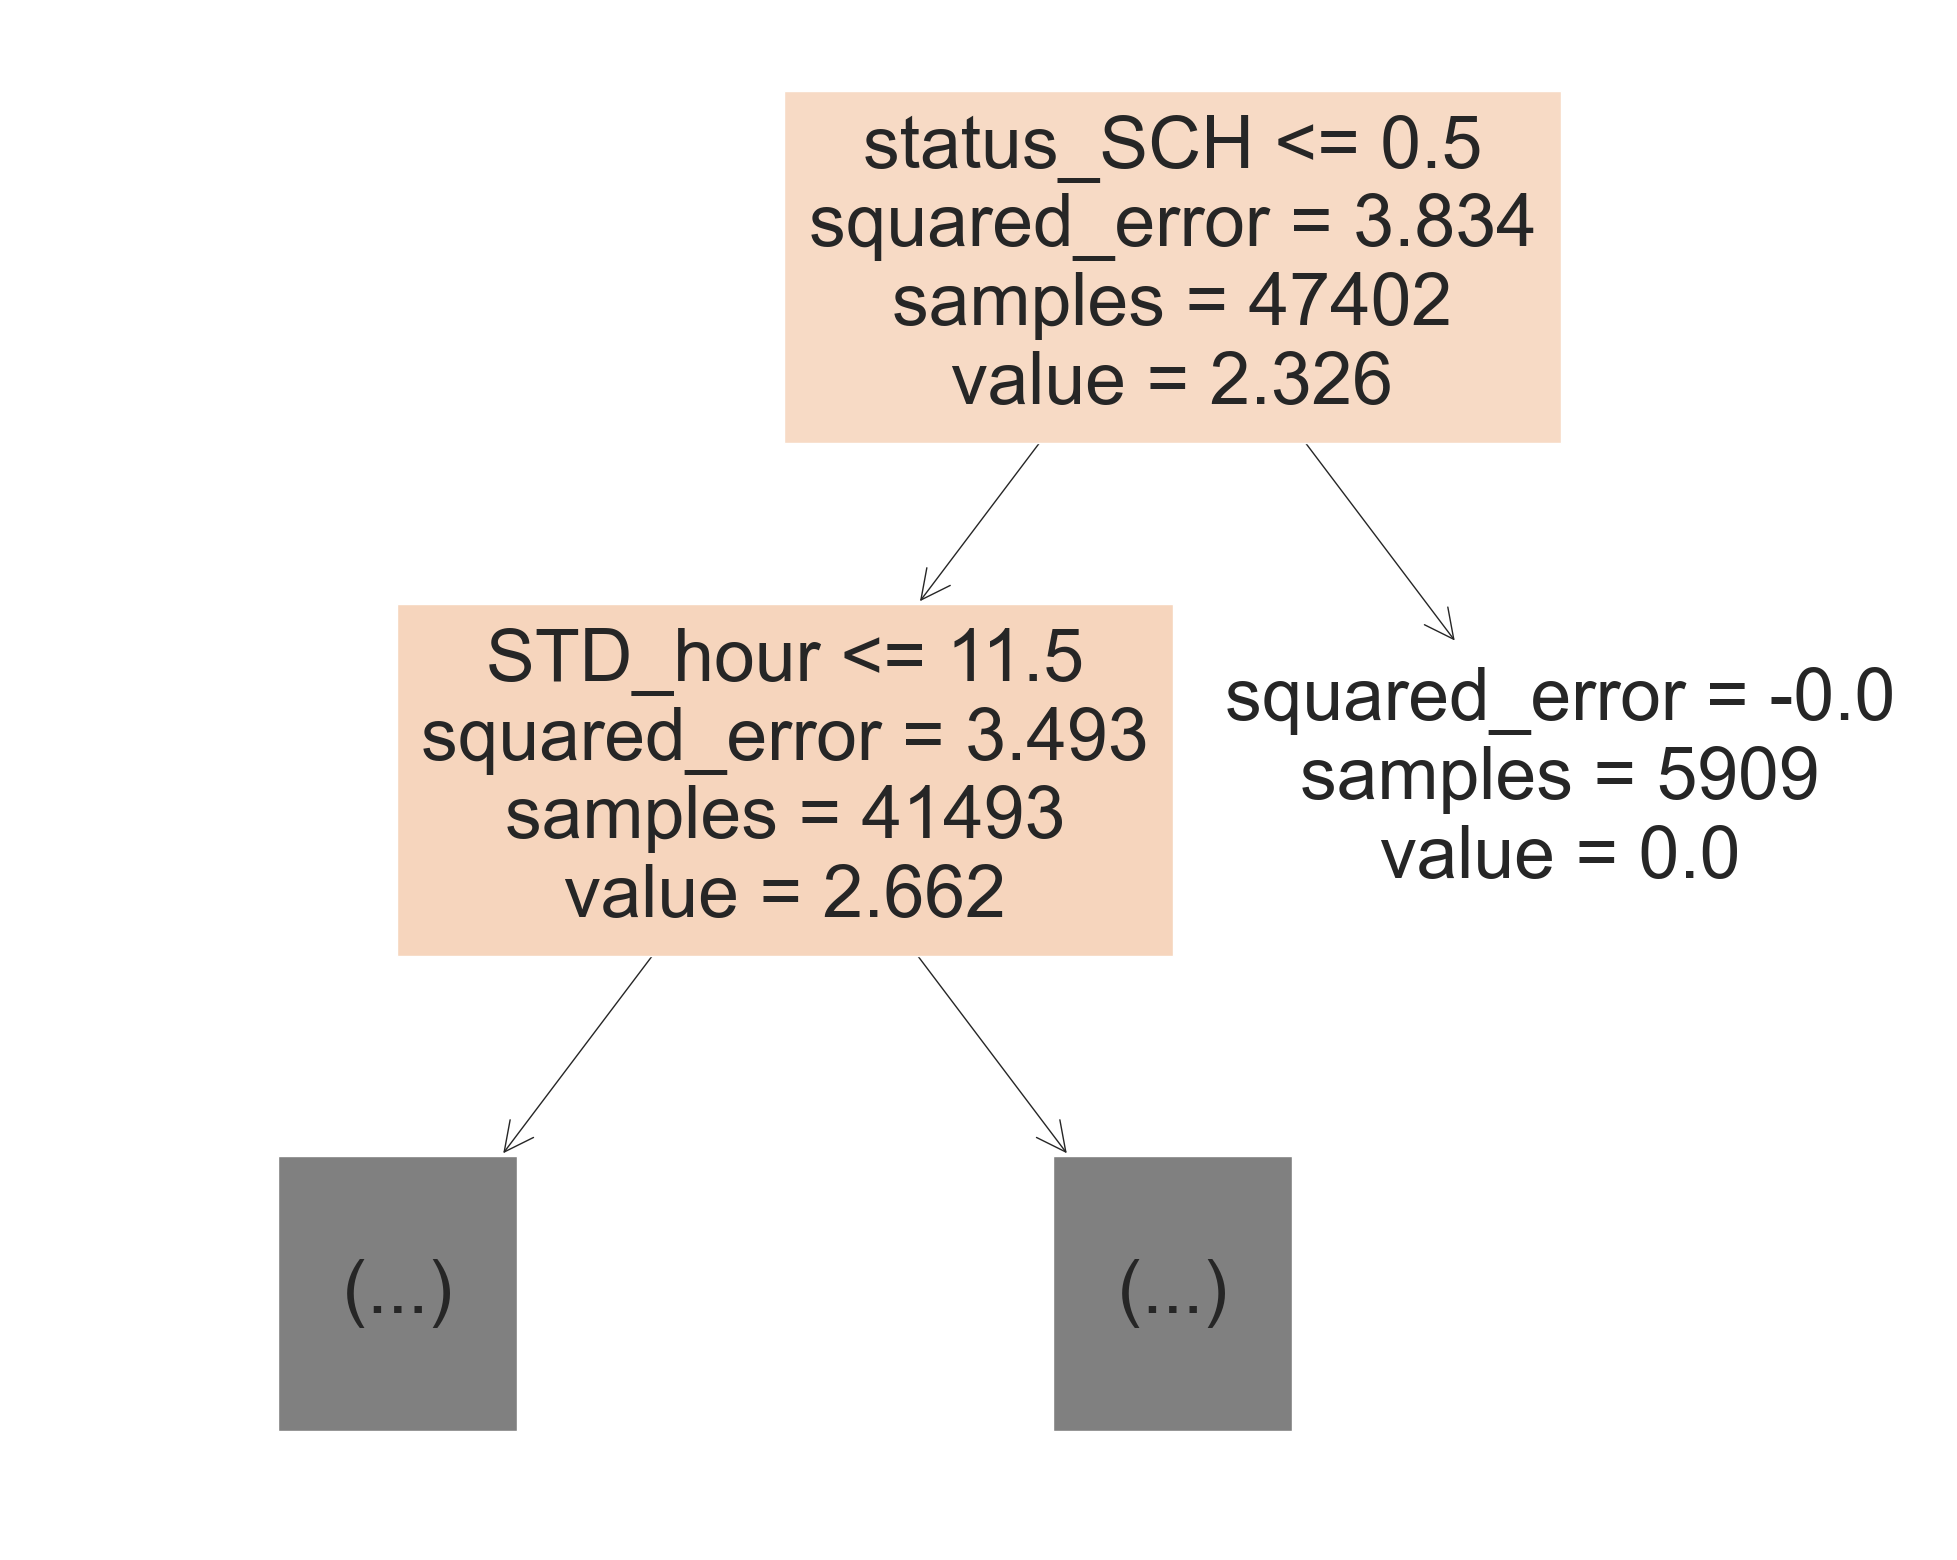

In [555]:
# Extract the first decision tree from the RandomForestRegressor
first_tree = model_dtc.estimators_[0]

# Plot the first decision tree
fig = plt.figure(figsize=(25, 20))
dectree_plot = plot_tree(first_tree, max_depth=1, filled=True, feature_names=features)

In [330]:
ideal = y_test.copy()
acc_ideal = abs(ideal - y_test)
acc_ideal[acc_ideal<=10] = 1
acc_ideal[acc_ideal>10] = 0

baseline = y_test.copy()
baseline[baseline <1000000] = 0
acc_baseline = abs(baseline - y_test)
acc_baseline[acc_baseline<=10] = 1
acc_baseline[acc_baseline>10] = 0

acc_0_1 = abs(pred_test_dtc - y_test)
acc_0_1[acc_0_1<=10] = 1
acc_0_1[acc_0_1>10] = 0

y_test_log = np.log1p(y_test)


acc_combined_df = pd.DataFrame({'y_test': y_test, 'y_test_log': y_test_log, 'ideal': acc_ideal, 'baseline': acc_baseline,'acc_0_1': acc_0_1})

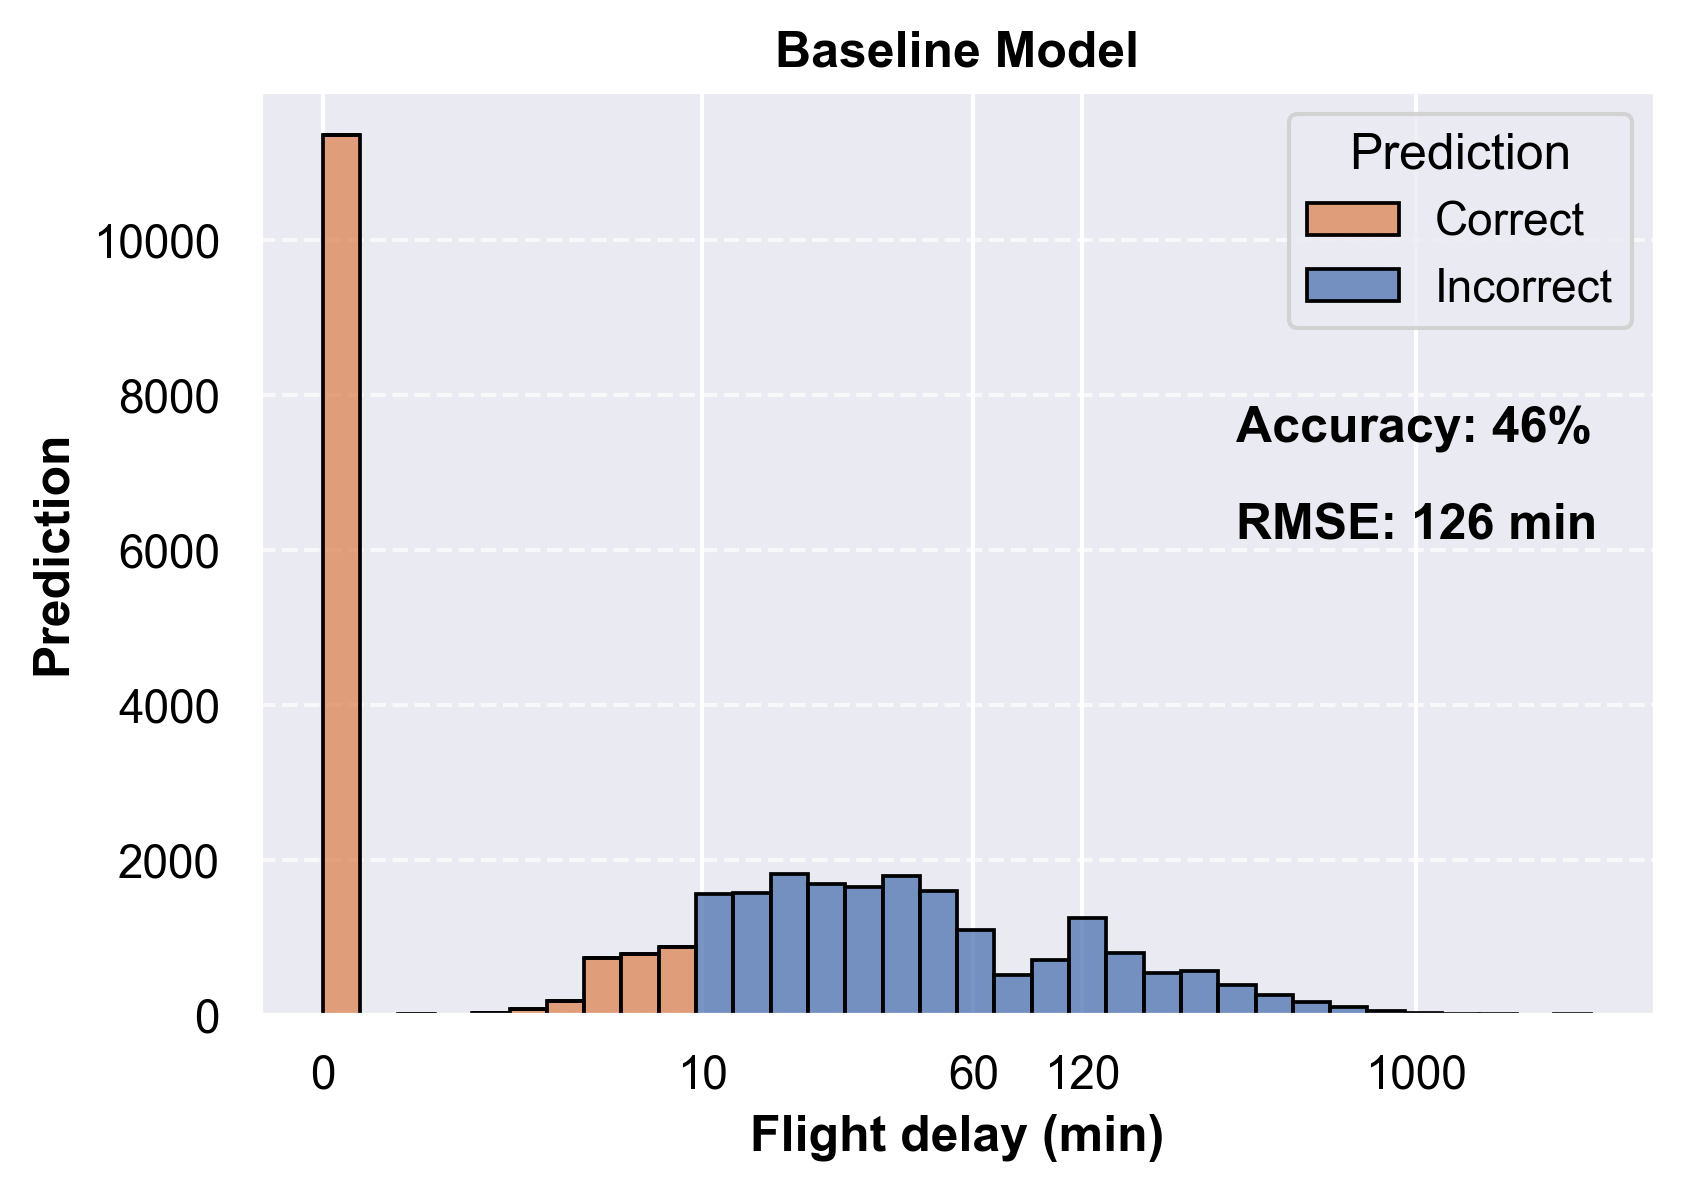

In [413]:
sns.set_theme(rc={'figure.figsize':(6,4)})
plt.figure(dpi=300)
hist = sns.histplot(acc_combined_df,x="y_test_log",hue="baseline",multiple="stack", edgecolor="black", color="black")
plt.title("Baseline Model",weight="bold", color="black")
plt.xlabel("Flight delay (min)",weight="bold", color="black")
plt.ylabel("Prediction",weight="bold", color="black")
legend = plt.legend(title="Prediction", loc='upper right', labels=['Correct', 'Incorrect'], labelcolor="black")
# Add text annotations to the plot
plt.setp(legend.get_title(), color='black')
plt.text(0.7, 0.62, "Accuracy: 46%", transform=plt.gca().transAxes, fontsize=12, weight="bold", color="black")
plt.text(0.7, 0.515, "RMSE: 126 min", transform=plt.gca().transAxes, fontsize=12, weight="bold", color="black")
#plt.text(0.5, 0.85, "RMSE: 100", transform=plt.gca().transAxes, fontsize=12, weight="bold", color="black")
plt.grid(axis='y', linestyle='--', alpha=0.7)
custom_ticks = [0,10, 60, 120, 1000]  # Define the desired tick positions (non-log-transformed values)
log_ticks = np.log1p(custom_ticks)  # Transform the custom ticks to log scale
plt.yticks(color="black")
plt.xticks(log_ticks, labels=[f"{tick}" for tick in custom_ticks], color="black")  # Set the custom tick labels
plt.show()

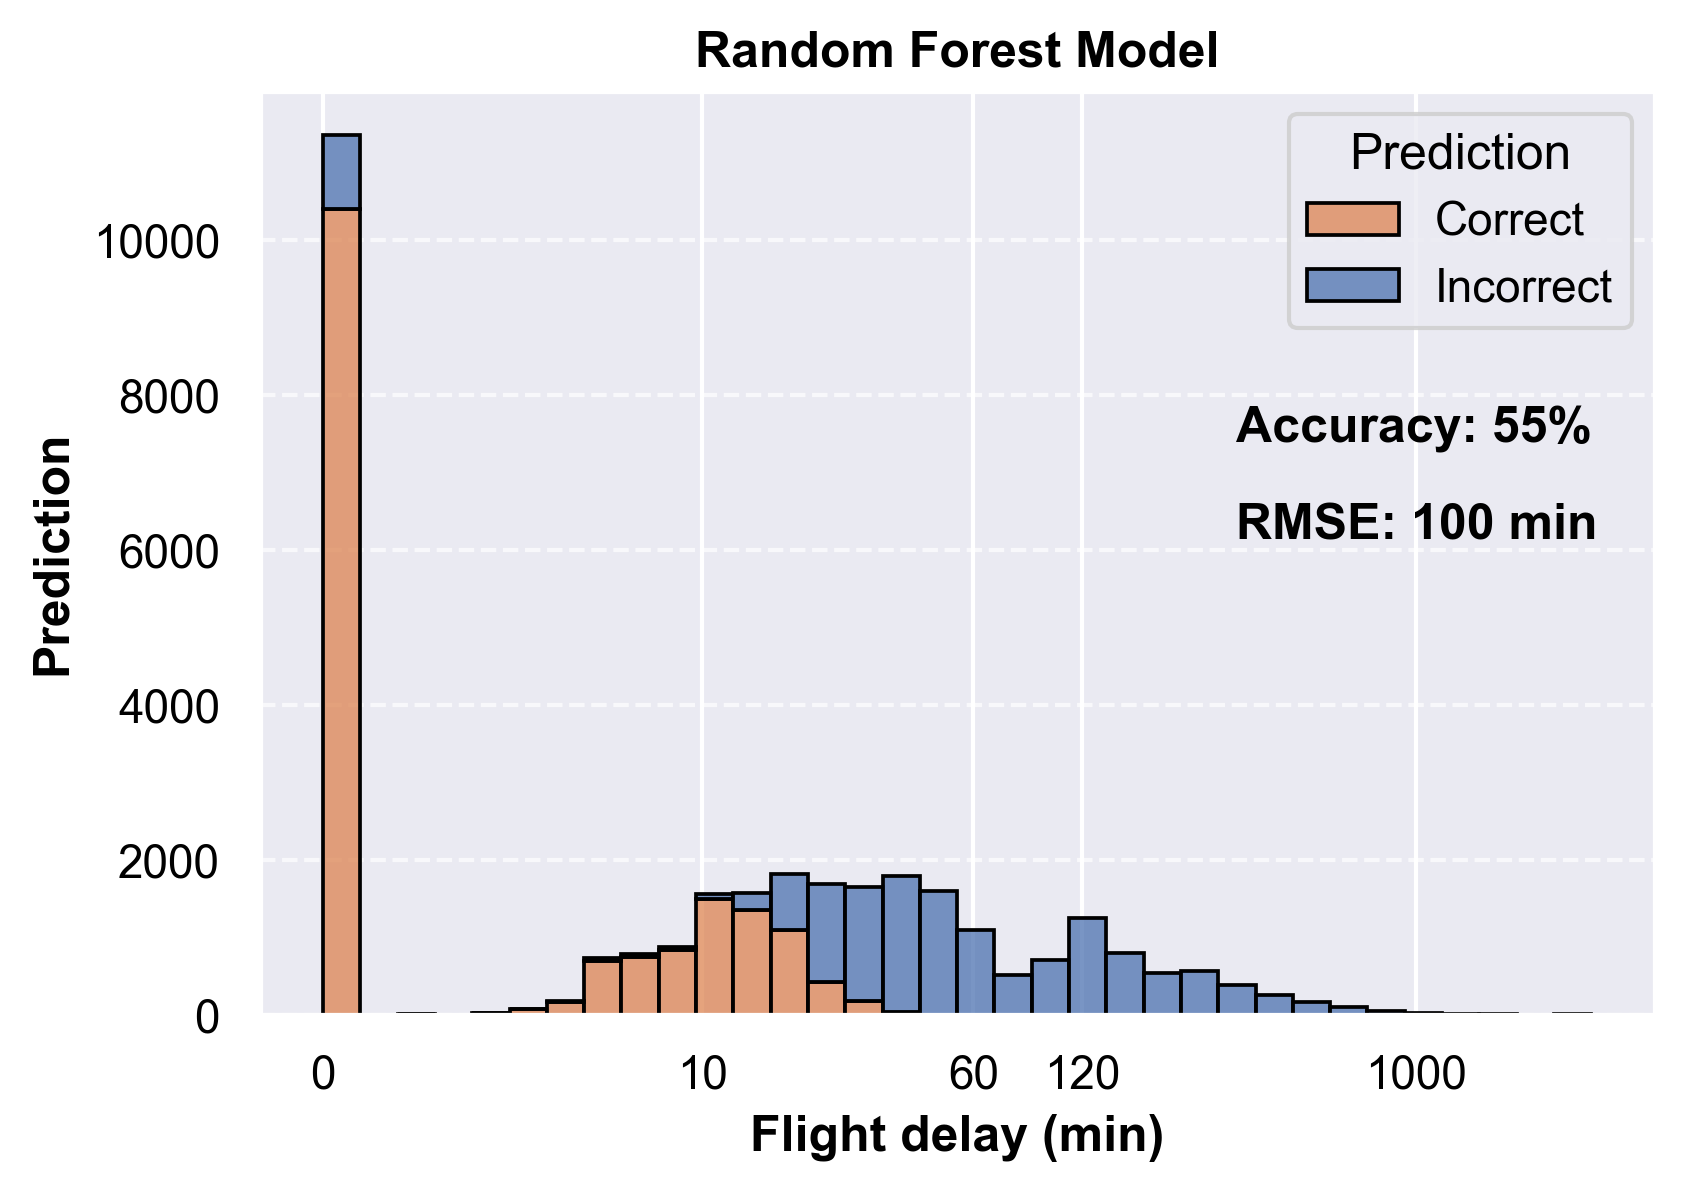

In [414]:
sns.set_theme(rc={'figure.figsize':(6,4)})
plt.figure(dpi=300)
hist = sns.histplot(acc_combined_df,x="y_test_log",hue="acc_0_1",multiple="stack", edgecolor="black", color="black")
plt.title("Random Forest Model",weight="bold", color="black")
plt.xlabel("Flight delay (min)",weight="bold", color="black")
plt.ylabel("Prediction",weight="bold", color="black")
legend = plt.legend(title="Prediction", loc='upper right', labels=['Correct', 'Incorrect'], labelcolor="black")
# Add text annotations to the plot
plt.setp(legend.get_title(), color='black')
plt.text(0.7, 0.62, "Accuracy: 55%", transform=plt.gca().transAxes, fontsize=12, weight="bold", color="black")
plt.text(0.7, 0.515, "RMSE: 100 min", transform=plt.gca().transAxes, fontsize=12, weight="bold", color="black")
#plt.text(0.5, 0.85, "RMSE: 100", transform=plt.gca().transAxes, fontsize=12, weight="bold", color="black")
plt.grid(axis='y', linestyle='--', alpha=0.7)
custom_ticks = [0,10, 60, 120, 1000]  # Define the desired tick positions (non-log-transformed values)
log_ticks = np.log1p(custom_ticks)  # Transform the custom ticks to log scale
plt.yticks(color="black")
plt.xticks(log_ticks, labels=[f"{tick}" for tick in custom_ticks], color="black")  # Set the custom tick labels
plt.show()

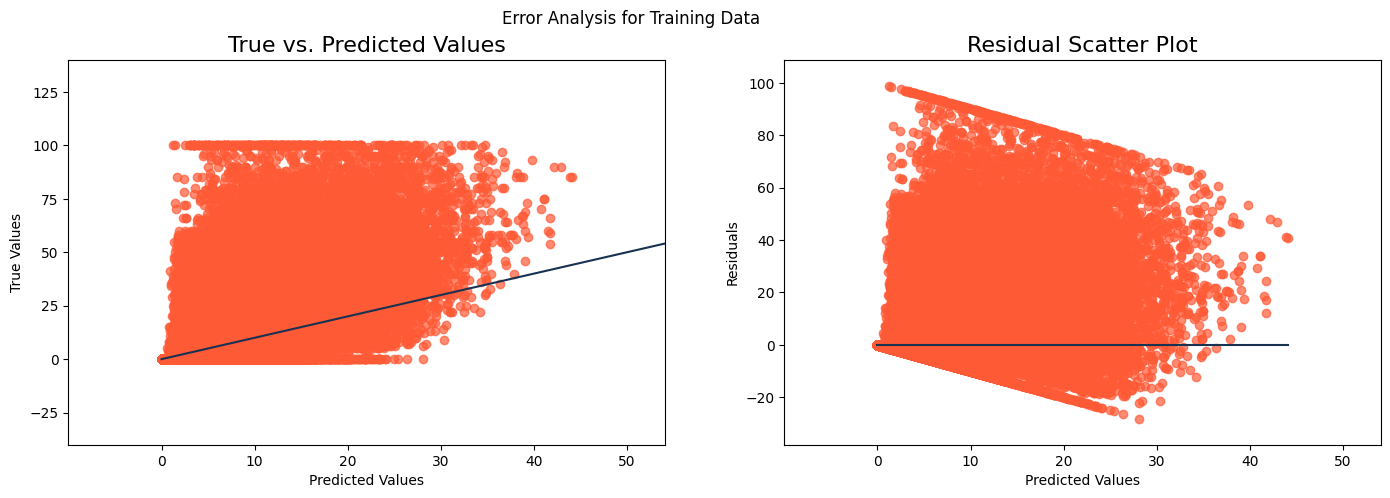

In [82]:
# Calculate residuals
residuals_train = y_train - pred_train_dtc

# Plot true vs. predicted values and residuals
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(right=1)
plt.suptitle('Error Analysis for Training Data')

# True vs. predicted values
ax[0].scatter(pred_train_dtc, y_train, color="#FF5A36", alpha=0.7)
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color="#193251")
ax[0].set_title("True vs. Predicted Values", fontsize=16)
ax[0].set_xlabel("Predicted Values")
ax[0].set_ylabel("True Values")
ax[0].set_xlim((pred_train_dtc.min() - 10), (pred_train_dtc.max() + 10))
ax[0].set_ylim((y_train.min() - 40), (y_train.max() + 40))

# Residual scatter plot
ax[1].scatter(pred_train_dtc, residuals_train, color="#FF5A36", alpha=0.7)
ax[1].plot([pred_train_dtc.min(), pred_train_dtc.max()], [0, 0], color="#193251")
ax[1].set_title("Residual Scatter Plot", fontsize=16)
ax[1].set_xlabel("Predicted Values")
ax[1].set_ylabel("Residuals")
ax[1].set_xlim((pred_train_dtc.min() - 10), (pred_train_dtc.max() + 10))
ax[1].set_ylim((residuals_train.min() - 10), (residuals_train.max() + 10))

plt.show()

In [663]:
from sklearn.metrics import make_scorer

# Define the custom scoring function
def custom_accuracy(y_true, y_pred):
    acc = abs(y_pred - y_true)
    acc[acc < 10] = 0
    zero_count = (acc == 0).sum()
    return zero_count / len(acc)

# Create the scorer
custom_scorer = make_scorer(custom_accuracy, greater_is_better=True)

# Create the parameters list you wish to tune
parameter_grid_rf = {
    'n_estimators': [200],
    'max_depth': [15,25],
    'min_samples_leaf':[1,2,3],
    'min_samples_split':[3,4,5],
    'max_features': ['sqrt'],
    'bootstrap': [False]
}

# Perform the grid search
gs_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=RSEED),
    param_grid=parameter_grid_rf,
    n_jobs=-1,
    scoring=custom_scorer,
    cv=3,
    verbose=5
)

gs_rf.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [15, 25],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [200]},
             scoring=make_scorer(custom_accuracy), verbose=5)

In [664]:
best_model_rf = gs_rf.best_estimator_
print("Best parameters found: ", best_model_rf)
y_test = np.expm1(y_test)
y_train = np.expm1(y_train)
pred_test_rf_grid = np.expm1(best_model_rf.predict(X_test))
pred_train_rf_grid = np.expm1(best_model_rf.predict(X_train))  




#in case status DEL and SCH were excluded before the fit, we have to add them
#pred_test_rf_grid = np.concatenate((pred_test_rf_grid, test_combined_del_sch['target'].values))
#y_test = np.concatenate((y_test, test_combined_del_sch['target'].values))
#pred_train_rf_grid = np.concatenate((pred_train_rf_grid, train_combined_del_sch['target'].values))
#y_train = np.concatenate((y_train, train_combined_del_sch['target'].values))


calculate_metrics(y_train, pred_train_rf_grid, y_test, pred_test_rf_grid )

features = X.columns  # Use the column names of the original DataFrame X as features
fi_rf_grid = pd.DataFrame({'feature': features,
                   'importance': best_model_rf.feature_importances_}).\
                    sort_values('importance', ascending=False)
fi_rf_grid.head(10)

Best parameters found:  RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=3, n_estimators=200, random_state=42)
Metrics on training data
Number of correct predictions: 64.93%
MAE:  12.136
RMSE: 19.799
R2: 0.076
------------------------------
Metrics on test data
Number of correct predictions: 54.30%
MAE:  43.103
RMSE: 117.678
R2: -0.107
------------------------------


,feature,importance
6,status_ATA,0.150028
10,status_SCH,0.128400
5,DURATION,0.082382
4,STA_hour,0.058281
14,DEP_lon,0.055077
289,plane_AT7,0.050120
3,STD_hour,0.049909
13,DEP_lat,0.049336
11,DATOP_DEP_count,0.044880
16,ARR_lon,0.035776


In [665]:
# Extract parameters and scores from GridSearchCV results
results_df = pd.DataFrame(gs_rf.cv_results_['params'])
results_df['mean_test_score'] = gs_rf.cv_results_['mean_test_score']
results_df['rank_test_score'] = gs_rf.cv_results_['rank_test_score']
#sort reults by rank
results_df = results_df.sort_values(by='rank_test_score')
# Display the DataFrame
results_df.head(10)

,bootstrap,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,mean_test_score,rank_test_score
0,False,15,sqrt,1,3,200,1.0,1
15,False,25,sqrt,3,3,200,1.0,1
14,False,25,sqrt,2,5,200,1.0,1
13,False,25,sqrt,2,4,200,1.0,1
12,False,25,sqrt,2,3,200,1.0,1
11,False,25,sqrt,1,5,200,1.0,1
10,False,25,sqrt,1,4,200,1.0,1
9,False,25,sqrt,1,3,200,1.0,1
8,False,15,sqrt,3,5,200,1.0,1
7,False,15,sqrt,3,4,200,1.0,1


In [1525]:
best_model_rf = gs_rf.best_estimator_
print("Best parameters found: ", best_model_rf)
pred_test_rf_grid = best_model_rf.predict(X_test)
pred_train_rf_grid = best_model_rf.predict(X_train)


calculate_metrics(y_train, pred_train_rf_grid, y_test, pred_test_rf_grid )

features = X.columns  # Use the column names of the original DataFrame X as features
fi_rf_grid = pd.DataFrame({'feature': features,
                   'importance': best_model_rf.feature_importances_}).\
                    sort_values('importance', ascending=False)
fi_rf_grid.head(10)

Best parameters found:  RandomForestRegressor(bootstrap=False, max_depth=25, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=4, n_estimators=400,
                      random_state=42)
Metrics on training data
Number of correct predictions: 75.69%
MAE:  6.748
RMSE: 9.856
R2: 0.754
------------------------------
Metrics on test data
Number of correct predictions: 47.94%
MAE:  40.198
RMSE: 113.131
R2: -0.023
------------------------------


,feature,importance
11,DATOP_DEP_count,0.127991
1,STD_month,0.111917
12,DATOP_ARR_count,0.097819
5,DURATION,0.081183
10,status_SCH,0.080336
3,STD_hour,0.073000
4,STA_hour,0.072070
6,status_ATA,0.064769
2,STD_day,0.062020
14,DEP_lon,0.060663


In [ ]:
# Extract parameters and scores from GridSearchCV results
results_df = pd.DataFrame(gs_rf.cv_results_['params'])
results_df['mean_test_score'] = gs_rf.cv_results_['mean_test_score']
results_df['rank_test_score'] = gs_rf.cv_results_['rank_test_score']
#sort reults by rank
results_df = results_df.sort_values(by='rank_test_score')
# Display the DataFrame
results_df.head(10)

In [1522]:
# Extract parameters and scores from GridSearchCV results
results_df = pd.DataFrame(gs_rf.cv_results_['params'])
results_df['mean_test_score'] = gs_rf.cv_results_['mean_test_score']
results_df['rank_test_score'] = gs_rf.cv_results_['rank_test_score']
#sort reults by rank
results_df = results_df.sort_values(by='rank_test_score')
# Display the DataFrame
results_df.head(10)

,bootstrap,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,mean_test_score,rank_test_score
2,False,25,sqrt,2,10,400,0.327238,1
0,False,25,sqrt,2,4,400,NaN,2
1,False,25,sqrt,2,5,400,NaN,2
3,False,25,sqrt,3,4,400,NaN,2
4,False,25,sqrt,3,5,400,NaN,2
5,False,25,sqrt,3,10,400,NaN,2
6,False,30,sqrt,2,4,400,NaN,2
7,False,30,sqrt,2,5,400,NaN,2
8,False,30,sqrt,2,10,400,NaN,2
9,False,30,sqrt,3,4,400,NaN,2


In [1515]:
# Extract parameters and scores from GridSearchCV results
results_df = pd.DataFrame(gs_rf.cv_results_['params'])
results_df['mean_test_score'] = gs_rf.cv_results_['mean_test_score']
results_df['rank_test_score'] = gs_rf.cv_results_['rank_test_score']
#sort reults by rank
results_df = results_df.sort_values(by='rank_test_score')
# Display the DataFrame
results_df.head(10)

,bootstrap,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,mean_test_score,rank_test_score
20,False,20,sqrt,3,4,400,0.557533,1
19,False,20,sqrt,3,3,400,0.557533,1
18,False,20,sqrt,3,2,400,0.557533,1
23,False,20,sqrt,4,4,400,0.556406,4
22,False,20,sqrt,4,3,400,0.556406,4
21,False,20,sqrt,4,2,400,0.556406,4
26,False,20,sqrt,5,4,400,0.554622,7
24,False,20,sqrt,5,2,400,0.554622,7
25,False,20,sqrt,5,3,400,0.554622,7
9,False,15,sqrt,3,2,400,0.545779,10


In [ ]:
best_model_rf = gs_rf.best_estimator_
print("Best parameters found: ", best_model_rf)
pred_test_rf_grid = best_model_rf.predict(X_test)
pred_train_rf_grid = best_model_rf.predict(X_train)

#in case status DEL and SCH were excluded before the fit, we have to add them
pred_test_rf_grid = np.concatenate((pred_test_rf_grid, test_combined_del_sch['target'].values))
y_test = np.concatenate((y_test, test_combined_del_sch['target'].values))
pred_train_rf_grid = np.concatenate((pred_train_rf_grid, train_combined_del_sch['target'].values))
y_train = np.concatenate((y_train, train_combined_del_sch['target'].values))


calculate_metrics(y_train, pred_train_rf_grid, y_test, pred_test_rf_grid )

features = X.columns  # Use the column names of the original DataFrame X as features
fi_rf_grid = pd.DataFrame({'feature': features,
                   'importance': best_model_rf.feature_importances_}).\
                    sort_values('importance', ascending=False)
fi_rf_grid.head(10)

Best parameters found:  RandomForestRegressor(bootstrap=False, max_depth=25, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=400, random_state=42)
Metrics on training data
Number of correct predictions: 69.00%
MAE:  8.118
RMSE: 11.669
R2: 0.656
------------------------------
Metrics on test data
Number of correct predictions: 47.90%
MAE:  40.138
RMSE: 113.15
R2: -0.023
------------------------------


,feature,importance
11,DATOP_DEP_count,0.120316
10,status_SCH,0.095806
1,STD_month,0.092700
5,DURATION,0.087060
12,DATOP_ARR_count,0.082524
3,STD_hour,0.078326
4,STA_hour,0.076020
6,status_ATA,0.072552
14,DEP_lon,0.066928
2,STD_day,0.053680


In [1482]:
best_model_rf = gs_rf.best_estimator_
print("Best parameters found: ", best_model_rf)
pred_test_rf_grid = best_model_rf.predict(X_test)
pred_train_rf_grid = best_model_rf.predict(X_train)

calculate_metrics(y_train, pred_train_rf_grid, y_test, pred_test_rf_grid )

features = X.columns  # Use the column names of the original DataFrame X as features
fi_rf_grid = pd.DataFrame({'feature': features,
                   'importance': best_model_rf.feature_importances_}).\
                    sort_values('importance', ascending=False)
fi_rf_grid.head(10)

Best parameters found:  RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      n_estimators=300, random_state=42)
Metrics on training data
Number of correct predictions: 80.69%
MAE:  5.799
RMSE: 8.878
R2: 0.801
------------------------------
Metrics on test data
Number of correct predictions: 47.70%
MAE:  40.243
RMSE: 113.089
R2: -0.022
------------------------------


,feature,importance
11,DATOP_DEP_count,0.137957
1,STD_month,0.117829
12,DATOP_ARR_count,0.110006
5,DURATION,0.077872
10,status_SCH,0.077617
3,STD_hour,0.072132
4,STA_hour,0.071674
2,STD_day,0.060603
6,status_ATA,0.058028
14,DEP_lon,0.055603


In [1480]:
best_model_rf = gs_rf.best_estimator_
print("Best parameters found: ", best_model_rf)
pred_test_rf_grid = best_model_rf.predict(X_test)
pred_train_rf_grid = best_model_rf.predict(X_train)

calculate_metrics(y_train, pred_train_rf_grid, y_test, pred_test_rf_grid )

features = X.columns  # Use the column names of the original DataFrame X as features
fi_rf_grid = pd.DataFrame({'feature': features,
                   'importance': best_model_rf.feature_importances_}).\
                    sort_values('importance', ascending=False)
fi_rf_grid.head(10)

Best parameters found:  RandomForestRegressor(max_depth=50, max_features='sqrt', n_estimators=200,
                      random_state=42)
Metrics on training data
Number of correct predictions: 86.35%
MAE:  4.798
RMSE: 7.214
R2: 0.868
------------------------------
Metrics on test data
Number of correct predictions: 47.43%
MAE:  40.366
RMSE: 113.12
R2: -0.023
------------------------------


,feature,importance
1,STD_month,0.148665
11,DATOP_DEP_count,0.148188
12,DATOP_ARR_count,0.132253
2,STD_day,0.078891
5,DURATION,0.072109
3,STD_hour,0.063168
4,STA_hour,0.062555
10,status_SCH,0.051350
0,STD_year,0.049992
6,status_ATA,0.043870
